# Wave2Vec2 paper notes and parameter calculations


In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.wavfile import read

### Some sample input

In [3]:
audio = read("sample.wav")
fs, X = audio
fs

16000

This corresponds to 16000 samples per second, i.e. 16000Hz or 16kHz

In [4]:
X.size/fs#audio length= 2.9 seconds

2.9248125

<AxesSubplot:>

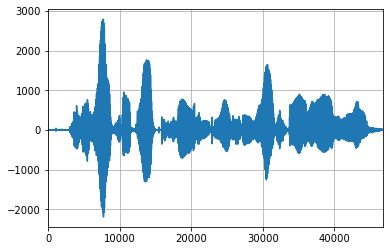

In [5]:
pd.Series(X).plot(grid=True)

In the paper they mention they normalized the raw audiofile, so I will also do that.

In [6]:
X = ((X - X.mean()) / X.std())

I use this occasion to learn some pytorch (never used it before)

In [7]:
import torch
from torch.nn import Conv1d
import torch.nn.functional as F

In [8]:
X = torch.tensor(audio[1])
X.shape

torch.Size([46797])

Note : input shape of conv operation expects (N, C, L), N: batch dim, C:channel dim, L:length of signal

In [9]:
X = X.view((1,1,46797))#reshape accordingly
X.shape

torch.Size([1, 1, 46797])

**Q** : How does the batching work if we have a bunch of instances with different lengths? Why can we not simply use the longest sequence and pad the rest? This would result in a constant $T$ for a given batch.

In [10]:
#change dtype
X = X.float()

In [11]:
#create some other input with another signal length to test
X1 = X[:,:,:22_000]
X2 = X[:,:,30_000:40_000]

### Wav2Vec2 Parameters

## A. temporal feature encoder block


From my understanding 1d conv is just a rolling dot product when applied in the time domain, thus a multi layer 1d conv is a rolling mlp.

####  params
a single conv operation is characterized by 
- the number of channels the input signal has. (for example 1 in the case of a raw 1-dim audio signal)
- the number of kernels applied on the input. (number of weight vectors in 1dconv)
- the size of the kernels.

Note that the output of the convolution operation will have a different length depending on the stride and padding and kernel size.


####  paper specifics 


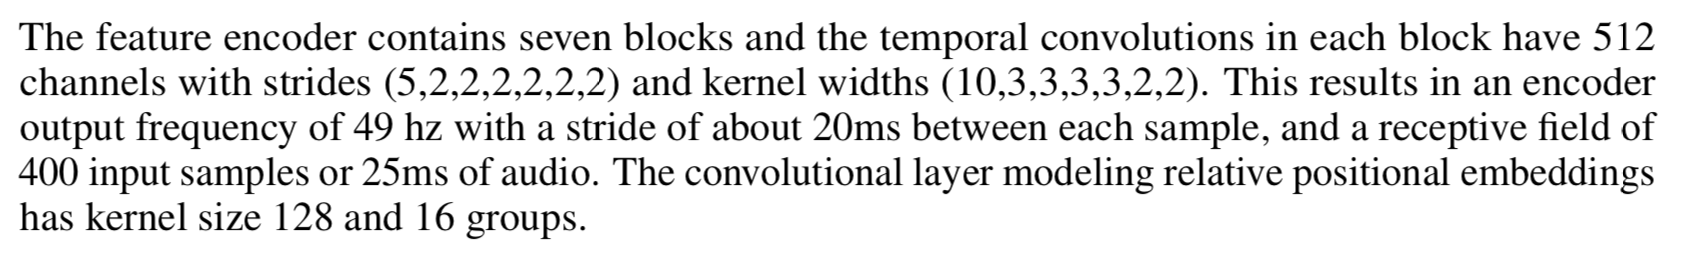

- The paper states that there are 7 layers with 512 kernels each.
- with kernel sizes 10,3,3,3,3,2,2 for the layers.

##### layer 1 
- 512 bias weights  (1 bias per kernel)
- 512x10 = 5120 weights
- total params : 5632
- or simply a {(512,1,10), (512,)} tensor set
- obviously the returning sequence will have 512 channels 

##### layer 2-5 
- 512 bias weights 
- Since input has 512 channels, each kernel has 512 columns.
- with 512 input channels (=512 columns per kernel) and a kernel size of 3, each kernel is a 3x512 matrix, containg 1536 params.
- Since we have 512 of these kernels, we have 512x1536=786432 weight parameters.
- total params : 786944
- or simply a {(512,512,3), (512,)} tensor set

##### layer 6-7
- 512 bias weights 
- Since input has 512 channels, each kernel has 512 columns.
- with 512 input channels and a kernel size of 2, each kernel is a 2x512 matrix, containg 1024 params.
- Since we have 512 of these kernels, we have 512x1024=524288 weight parameters.
- total params : 524800
- or simply a {(512,512,2), (512,)} tensor set


My calculations for the conv block : **5632 + 4x786944 + 2x524800 = 4203008 params**

**Q** : Even if the initial weights are random, how is it guaranteed that in a given layer there arent any two kernels who learn the same thing?

In [12]:
# layer 1 
l1 = Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=True)
# layer 2 - 5
l2 = Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=True)
l3 = Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=True)
l4 = Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=True)
l5 = Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=True)
# layer 6-7
l6 = Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=True)
l7 = Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=True)

In [13]:
print(X.shape, "\n")
y = l1(X)
print(y.shape, "\n")
y = l2(y)
print(y.shape, "\n")
y = l3(y)
print(y.shape, "\n")
y = l4(y)
print(y.shape, "\n")
y = l5(y)
print(y.shape, "\n")
y = l6(y)
print(y.shape, "\n")
y = l7(y)
print(y.shape, "\n")

torch.Size([1, 1, 46797]) 

torch.Size([1, 512, 9358]) 

torch.Size([1, 512, 4678]) 

torch.Size([1, 512, 2338]) 

torch.Size([1, 512, 1168]) 

torch.Size([1, 512, 583]) 

torch.Size([1, 512, 291]) 

torch.Size([1, 512, 145]) 



output length $L_out$ of the discrete sequence must be:
- $ L_{out} = L_{in} / (5*2*2*2*2*2*2)$

In [14]:
# length of output of the conv feat encoder should be 145 since:
y.shape[-1] == int(X.shape[-1] / 5 / 2 / 2 / 2 / 2 / 2 / 2) -1 == int(X.shape[-1]/(5*2*2*2*2*2*2)) -1 == 145 

True

In [15]:
# input with length 100_000 must yield the same
fs = 16_000
L_in = 100_000
print("L_in : ", L_in)
time = L_in/fs 
print("Length in s : ",time)
total_encoder_stride = (5*2*2*2*2*2*2)
L_out = L_in / total_encoder_stride
print("L_out : ", L_out)

out_capture = time / L_out
in_capture = time / L_in # i.e. 1/fs
print("in_capture : {:.7f}".format(in_capture))
print("out_capture : ", out_capture)

L_in :  100000
Length in s :  6.25
L_out :  312.5
in_capture : 0.0000625
out_capture :  0.02


In [16]:
# input with length 46_797
fs = 16_000
L_in = 46_797
print("L_in : ", L_in)
time = L_in/fs 
print("Length in s : ",time)
total_encoder_stride = (5*2*2*2*2*2*2)
L_out = L_in / total_encoder_stride
print("L_out : ", L_out)

out_capture = time / L_out
in_capture = time / L_in # i.e. 1/fs
print("in_capture : {:.7f}".format(in_capture))
print("out_capture : ", out_capture)

L_in :  46797
Length in s :  2.9248125
L_out :  146.240625
in_capture : 0.0000625
out_capture :  0.02


Output of the feature encoder : $T=145$ vectors

In [17]:
y.shape

torch.Size([1, 512, 145])

In [18]:
L_in/145

322.73793103448276

In [19]:
(L_in/145) / 16_000 

0.020171120689655174

the first latent speech representation ``y[0,:,0]`` ($\mathcal{Z}_{0} \in \mathcal{R}^{512}$) should represents the first 400 data points of the inputwave, i.e. $\frac{400}{16000} = 0.025s = 25 ms$.

In [20]:
y[0,:,0].dim(), y[0,:,0].shape

(1, torch.Size([512]))

### B. Context module (BASE - 12 transformer blocks)

#### B.1 transformer block

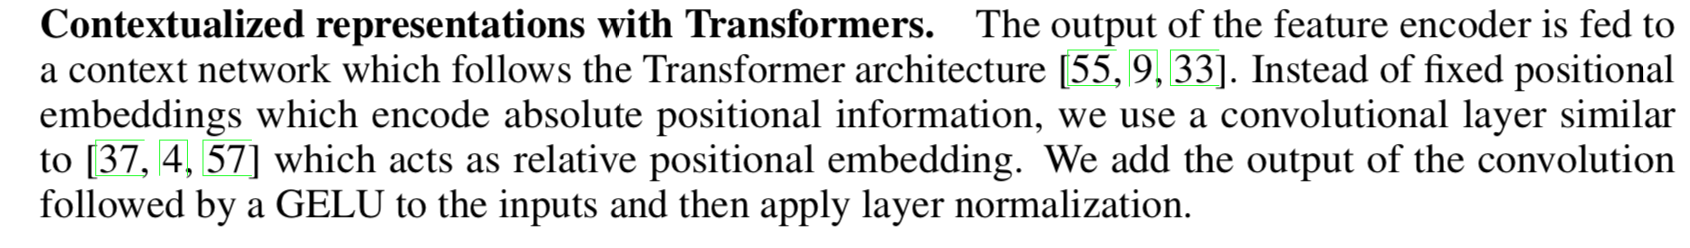

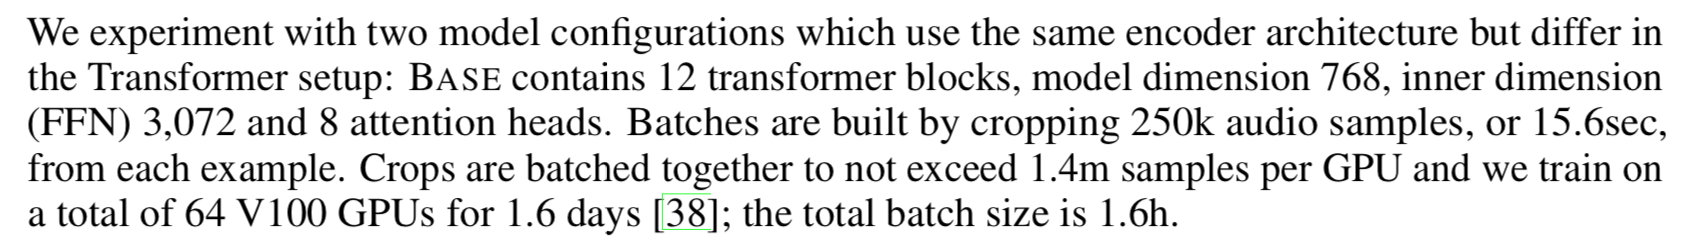

The paper states a model dimension of 768 for the transformer, i.e. each vector $Z_t \in \mathcal{R}^{768}$, but we actually observe $Z_t \in \mathcal{R}^{512}$.

In [21]:
from torch.nn import Linear

In [22]:
linmap = Linear(in_features=512, out_features=768, bias=True)

Pytorch linear object requires a different kind of dim order I guess :

$(N, C, T) \gets (N, T, C)$

So I swap the dims accordingly

In [23]:
y = torch.transpose(y,1,2)

In [24]:
y.shape

torch.Size([1, 145, 512])

In [25]:
y = linmap(y)

In [26]:
y.shape

torch.Size([1, 145, 768])

Reshape again according to the expected shape of conv layer

$(N, T, C) \gets (N, C, T)  $

In [27]:
y = torch.transpose(y,1,2)

In [28]:
y.shape

torch.Size([1, 768, 145])

The linear mapping  is learnable and the parameters are $W, B$ (i.e. set of 768 lineqs)

- $W \in \mathcal{R}^{512\times768}$ contains 512x768 = 393216 weights.
- One bias term per y, in total 768
- params in total : 393984
- or tensor set {(768, ), (768, 512)}

Before feeding $Z$ into the context module, we extract a positional encoding using temporal conv. as specified in the paper

paper : "*The convolutional layer modeling relative positional embeddings has kernel size 128 and 16 groups*"

Although im not sure why exactly this grouping makes sense other than reducing parameter size, setting the kernel size to 128 with no padding will shrink $T$T. Since the paper mentions that $T$ is fed into the transformer, it is likely that the input is being padded. If we add half the size of the kernel on each side we can avoid this, i.e. padding=kernel_size=128, meaning 64 at each boundary.

In [29]:
L_out = lambda padding, kernel_size, stride, L_in : (L_in + 2*padding - kernel_size)/(stride) + 1
L_out(0,128,1,145)

18.0

In [32]:
pos_encoder = Conv1d(768, 768, kernel_size=128, stride=1, padding=int(128/2), groups=16)

In [33]:
pos_encoder(y).shape # this will work 

torch.Size([1, 768, 146])

In [34]:
y = pos_encoder(y)

In [35]:
y.shape

torch.Size([1, 768, 146])

- The pos encoder has 768 bias' parameters (1 for each kernel).
- Although the input has 768 channels, each kernel only has 768/16 = 48 columns (because group=16)
- Since the length of each kernel is 128, kernels are 128x48
- weights : 768 x (48 x 128) = 4718592
- bias : 768
- params : 768 + 768 x (48 x 128) = 4719360
- or tensor set {(768, ), (768, 48, 128)}.

**Q**: I understand the underlying calculations based on the tensor shapes and the parameters of this layer, but I dont get why this encodes relative information and also why $T \gets T + 1$.

Now we can pass it to the context module.


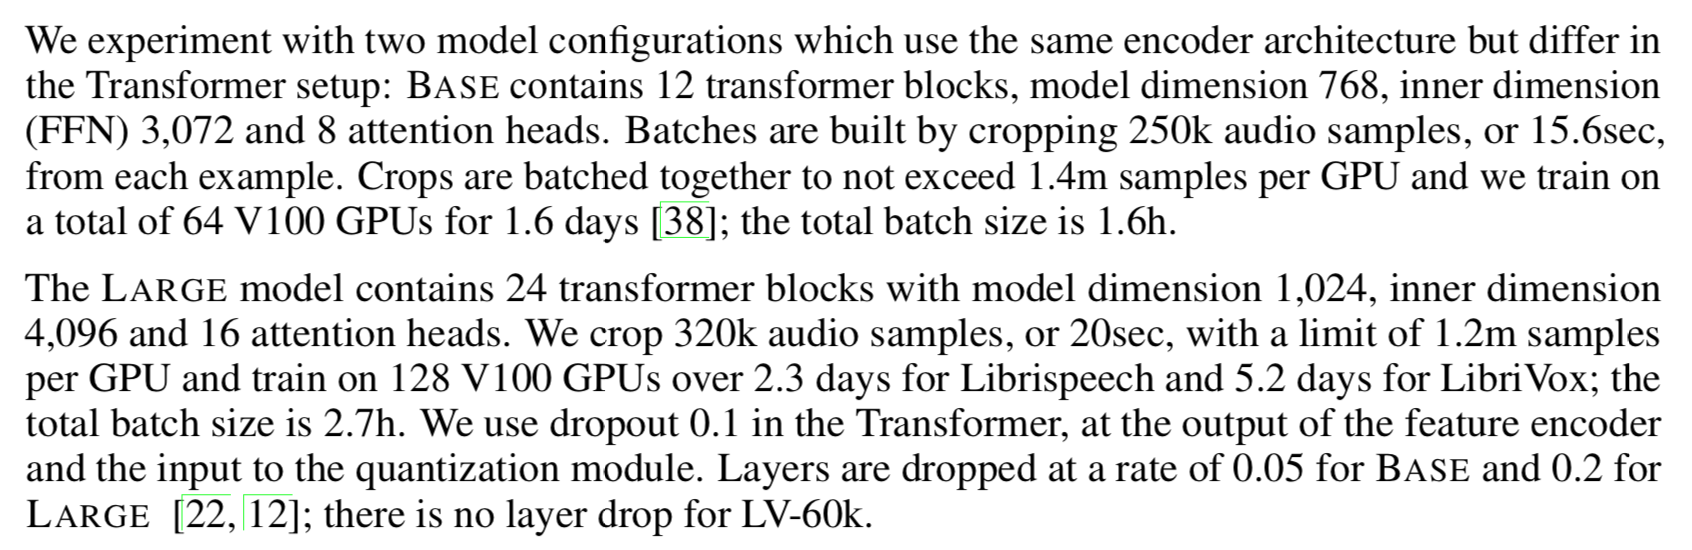

##### 0) Recap of basic self attention

For a given set $X$, containing $T$ vectors, self attention produces the set $Y$ with $T$ vectors. ($x_i \to y_i$)

- $y_i = \sum_{j} w_{ij} x_{i}$

- with $w_{ij} = x_{i}^{\bf{T}} x_{j}$

- For each $x_i$ you basically collect the dot products with the other vectors $x_{-i}$.

- apply softmax  :

- $ w_{ij} \gets \frac{exp(w_{ij})}{\sum_{j} exp(w_{ij})}  \in [0,1]$

- I think thats basically self attention

reshape for passing to linear map

$(N, C, T) \gets (N, T, C)$

In [40]:
y = torch.transpose(y,1,2)
y.shape

torch.Size([1, 146, 768])

E.g. $w_{0,1} = x_{0}^{T} x_{1}$

In [36]:
y[0,0,:]@y[0,1,:] # == torch.matmul(y[0,0,:].T, y[0,1,:])

tensor(16.8972, grad_fn=<DotBackward>)

##### 1) Attention Parameterization

Each $x_i$ is used in three different ways (i.e. has 3 roles):

- Query : $x_i$ is used when comparing it to every other vector $x_j$ to collect the weights for its own output $y_i$.
- Key   : $x_i$ is used when comparing it to every other vector $x_j$ to collect the weights for their  output $y_j$.
- Value : $x_i$ is used when the weighted sum is computed for each $y_t$.


For each of the three roles we derive a new vector by applying a linear transformation to $x_i$

- $q_i \gets W_{q} x_i$
- $k_i \gets W_{k} x_i$
- $v_i \gets W_{v} x_i$


Then

- $w_{ij} = q_{i}^{\bf{T}} k_{j}$ 

- $y_i = \sum_{j} w_{ij} v_{i}$



Note : In the papers they scale the dot-product like this :

-  $w_{ij} \gets  \frac{w_{ij}}{\sqrt{k}}$

**Q** : Is this just for moderating the values fed into the softmax?

In [50]:
y[0].shape# recap that T=146, k=768

torch.Size([146, 768])

In [49]:
W_q = Linear(in_features=768, out_features=768, bias=True)
W_k = Linear(in_features=768, out_features=768, bias=True)
W_v = Linear(in_features=768, out_features=768, bias=True)

In [52]:
Q = W_q(y)# W_q X
K = W_q(y)# W_k X
V = W_q(y)# W_v X

In [63]:
Q.shape

torch.Size([1, 146, 768])

In [54]:
Q.shape == y.shape 

True

In [53]:
Q[0,:,0].shape # sequence dim T=146

torch.Size([146])

$W_q x_2$ :

In [55]:
Q[0,2,:].shape # W_q x_2 

torch.Size([768])

$w_{0,1} = q_{0}^{\bf{T}} k_{1}$

In [56]:
Q[0,0,:]@K[0,1,:]# == torch.matmul(Q[0,0,:].T, K[0,1,:])

tensor(-154.9566, grad_fn=<DotBackward>)

Now take dot product for the whole sequence (bmm can take care of the batch dim)

In [57]:
# check if that makes sense
Q[0,:,:]@K.transpose(1,2)[0,:,:] == torch.bmm(Q, K.transpose(1, 2))

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

Now let

- raw weights <- $Q  K^{T}$

- scaled weights <- $\frac{Q K^{T}}{\sqrt{k}}$


In [58]:
raw_weights = torch.bmm(Q, K.transpose(1, 2))

In [62]:
raw_weights.shape # (N, Xi, Xj) attention :  i --> j

torch.Size([1, 146, 146])

Sanity check !

$w_{0,1} == q_{0}^{\bf{T}} k_{1}$ == $(Q K^{T})_{0,1}$

In [59]:
raw_weights[0,0,1] # (batch=0, query=X0, key=X1)

tensor(-154.9566, grad_fn=<SelectBackward>)

In [60]:
Q[0,0,:]@K[0,1,:] # must be the same as the Q_{0} @ K_{1}

tensor(-154.9566, grad_fn=<DotBackward>)

In [61]:
torch.matmul(Q[0,0,:].T, K[0,1,:]) # equivalently

tensor(-154.9566, grad_fn=<DotBackward>)

Now I can compute the output

$y \gets (Q K^{T}) V$

In [64]:
y = torch.bmm(raw_weights, V)

In [65]:
y.shape

torch.Size([1, 146, 768])

### Multple attentions

- When using more than one attention operation ("head"), its just multiple of these operations distinct and in parallel.

- For input $x_i$ each attention head produces a different output vector $y_i$. We concatenate these, and pass them through a linear transformation to reduce the dimension back to k.

- Parametarization

- For each attention head $h$ :
    - $W_q, W_k, W_v$ : 768 (bias) + 768x768= 589824 (weigths) each
    - I.e. 3 * (768 + 768 * 768) = 1771776
   
- And then you concatenate all of the $h$ outputs, resulting in $h k$ dim.
- Finally, map back to $k$ by using a linear transformation ($h k \to k$)

- With $h=8$, that would be 14174208 parameters for the triplets.
- And for the final linear mapping, $(8 * 768) \times 768 \to 768$ another total of 768 + (8 * 768) * 768 = 4719360 parameters
   


If we would implement that, computation time increases $h$ fold.

#### MHDPA in practice

- In practice, the dimension of the triplets are split according to $\frac{k}{h}$. This reduces the dims of the triplets per head, but enables zero overhead.
- In our case $h=8$, $k=768$

- For each head $h$
    - $W_q, W_k, W_v \in \mathcal{R}^{96 \times 96}$
    
    - $Q_h \gets  W_q X$
    - $K_h \gets  W_k X$
    - $V_h \gets  W_v X$
    
    - $y_h \gets (Q_{h} K_{h}^{T}) V_h$
    
    - Then $y_{h, t} \in \mathcal{R}^{96}$
    
- The different attention heads with their corresponding matrices can all be jointly represented by $W_q, W_k, W_v$.


- Next, we concat the outputs of the 8 attention heads, then multiple them by an additional weights matrix $W_o$.

- $W_o \gets \mathcal{R}^{(96 \times 8) \times 768} $ (jointly learned)

- such that $y_t \gets concat(y_{1, t}, y_{2, t}, ..., y_{8, t}) W_o$



**Q** : Im not sure how the efficient version of MHDPA can be implemented in pytorch, but I assume this would mean there is the same number of params for any $h$ ?

In [67]:
W_o = Linear(in_features=768, out_features=768, bias=True)

In [68]:
y = W_o(y)

- This kind of implementation entails the use of 4 parameter sets, regardless of the choice of $h$.

- {$W_q,  W_k, W_v, W_o$} 

- Each $W_i$ has param tensor set {(768, 768), (786,)}

- trainable params : 4 * ( ( 768 * 768 ) + 768 ) = 2362368

- After that, there comes a Layernorm

In [69]:
y.shape

torch.Size([1, 146, 768])

In [70]:
y[0,-1,:].shape

torch.Size([768])

### layernorm

- As far as I understand, each sample $Y \in \mathcal{R}^{T \times 768}$ is being normalized over each of the 768 channels.
 - Each $y_t \in \mathcal{R}^{768}$ has 768 channels.
 - For each of these channels $c_i \in \mathcal{R}^{T}, \ i \in \{1,...,768 \}$ :
 
     - $c_i \gets Z(c_i) * w + b$
     
     
 - yield 2 * 768 = 1536 per layer
 


In [71]:
# norm for channel 0
c_0 = y[0,:,0]
norm_c_0 = (y[0,:,0] - y[0,:,0].mean()) / y[0,:,0].std()

<AxesSubplot:>

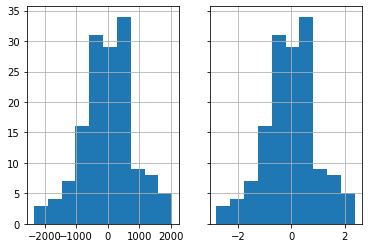

In [72]:
fig, axes = plt.subplots(1,2,sharey=True)
pd.Series(c_0.tolist()).hist(ax=axes[0])
pd.Series(norm_c_0.tolist()).hist(ax=axes[1])

Next, the resulting vectors are fed into a  single layer FC with inner dim of 3072.

- two weight sets are needed for the dense part

- $W_{in} : 768 \to 3072$ (weights : 768 * 3072) + 3072 bias

- $W_{out} : 3072 \to 768$ (weights : 3072 * 768) + 768 bias

- params = 768 * 3072 + 3072 * 768 + 3072 + 768 = 4722432

In [74]:
W_in = Linear(in_features=768, out_features=3072, bias=True)
W_out = Linear(in_features=3072, out_features=768,bias=True)

In [75]:
y = W_in(y)
y = W_out(y)

Now follows another layernorm, with total params (again) of 2 * 768 = 1536

#### Total params per transformer block

- MHDPA : 4 * ( ( 768 * 768 ) + 768 ) = 2362368
- norm  : 2 * 768 = 1536
- FC.   : (768 * 3072) + 3072 + (3072 * 768) + 768 = 4722432
- norm  : 2 * 768 = 1536

- total per block : 7087872

#### total params for all context module

- 12 * 7087872 = 85054464


### total params 

- Convolutions : 4203008

- linear mapping : 393984

- positional encoding : 4719360

- transformers : 85054464

- total : 94370816